# ***Graph Neural Networks for End-to-End Particle Identification with the CMS Experiment***
### *written by Khalid Bagus Pratama Darmadi, S.Si (Khalid); Papua, Indonesia*
*for ML4SCI on Google Summer of Code 2023*

Common Task 3. Deep Learning based Quark-Gluon Classification
Datasets:

> https://cernbox.cern.ch/index.php/s/hqz8zE7oxyPjvsL


Description: 125x125 matrices (three channel images) for two classes of particles quarks and gluons impinging on a calorimeter.
For a description of 1st dataset please refer to the link provided for the dataset.

> Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

> Discuss the resulting performance of the 2 chosen architectures. 

Please use a Convolutional Neural Network (CNN) architecture of your choice to achieve the highest possible classification on this dataset (in your preferred choice of framework for example: Tensorflow/Keras or Pytorch). Please provide a Jupyter notebook that shows your solution. 

# **Solution:**

***(From 3 separate datasets available, here we used the jet0_run1)***

For this task, here is the model description for classifying whether the output would be a quark or a gluon, with features X_jets, mean transverse momentum and mass. We are using the same preprocessed data as Task 2 (normalization), then with the generation of graph with edges to be used for training the model.

This graph-based architecture model was designed for purpose in effectively learns complex patterns from the graph representation of the input data, which includes Laplacian and Hessian features and additional features like mean transverse momentum and mass. The combination of GATConv and ChebConv layers allows the model to efficiently learn spatially localized patterns on the graph and consider the importance of neighboring nodes. The global average pooling, dense, and dropout layers help to create a robust classifier for quark-gluon classification.

1. Data preprocessing and graph creation


> The create_graph_from_features function creates a graph using Laplacian and Hessian features, along with additional features (mean transverse momentum and mass). You add edges to the graph based on k-nearest neighbors and Delaunay triangulation.

2. Spektral Graph creation

> The create_spektral_graph function takes the NetworkX graph and converts it into a Spektral Graph object, which includes the node attributes and adjacency matrix.

3. Jet Classifier

> *   Input layers: Two separate input layers for the node features (X) and adjacency matrix (A).
*   GATConv layers: Three GATConv layers with 32, 64, and 128 filters, and 4 attention heads each. These layers help the model learn different representations of the input graph while considering the importance of neighboring nodes during the learning process.
*   ChebConv layers: Three ChebConv layers with 128, 64, and 32 filters, and K=2 (Chebyshev order). ChebConv layers are spectral convolutional layers that efficiently learn spatially localized patterns on the graph. These layers help the model learn more complex patterns in the graph representation of the input data.
*   GlobalAvgPool layer: This layer computes the average of the node features, creating a global feature vector that represents the entire graph.
*   Dense and Dropout layers: Two dense layers with GELU and ReLU activation functions, respectively, learn higher-level abstractions of the global feature vector. Dropout layers (with a rate of 0.5) are used to prevent overfitting.

4. Output layer

> *   The final dense layer with one unit and a sigmoid activation function produces a probability value between 0 and 1, representing the likelihood of the input belonging to the positive class (either quark or gluon).

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
import pyarrow.parquet as pq

def save_data_batches(file_path, output_folder, batch_size=2267):
    os.makedirs(output_folder, exist_ok=True)
    
    file_name = os.path.basename(file_path)
    prefix = file_name.split('.')[0]
    
    parquet_file = pq.ParquetFile(file_path)
    
    for i, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size)):
        batch_df = batch.to_pandas()
        output_file_name = f"{prefix}_batch_{i+1}.parquet"
        output_file_path = os.path.join(output_folder, output_file_name)
        batch_df.to_parquet(output_file_path)

data_path = "/content/drive/MyDrive/GSoC/tasks_2_and_3"
file_names = [
    "QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet",
    "QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet",
    "QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet"
]

for file_name in file_names:
    file_path = os.path.join(data_path, file_name)
    output_folder = os.path.join(data_path, "batches", file_name.split('.')[0])
    save_data_batches(file_path, output_folder)

In [ ]:
# Assign folder containing the batch files
batch_folder = "/content/drive/MyDrive/GSoC/tasks_2_and_3/batches/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540"

batch_file = os.path.join(batch_folder, "QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540_batch_1.parquet")
df_batch = pd.read_parquet(batch_file)

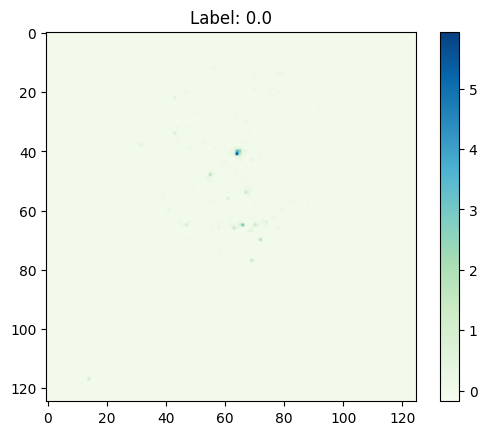

In [ ]:
import matplotlib.pyplot as plt

X_jets = np.stack([
    np.array(
        [item for sublist1 in x for sublist2 in sublist1 for item in sublist2], 
        dtype=np.float32
    ).reshape(len(x), len(x[0]), len(x[0][0])) 
    for x in df_batch['X_jets'].values
])

index = 0
image = X_jets[index]

plt.imshow(image[1], cmap='GnBu')  # Display the first layer of the 3D array
plt.colorbar()
plt.title(f"Label: {df_batch.iloc[index]['y']}")
plt.show()

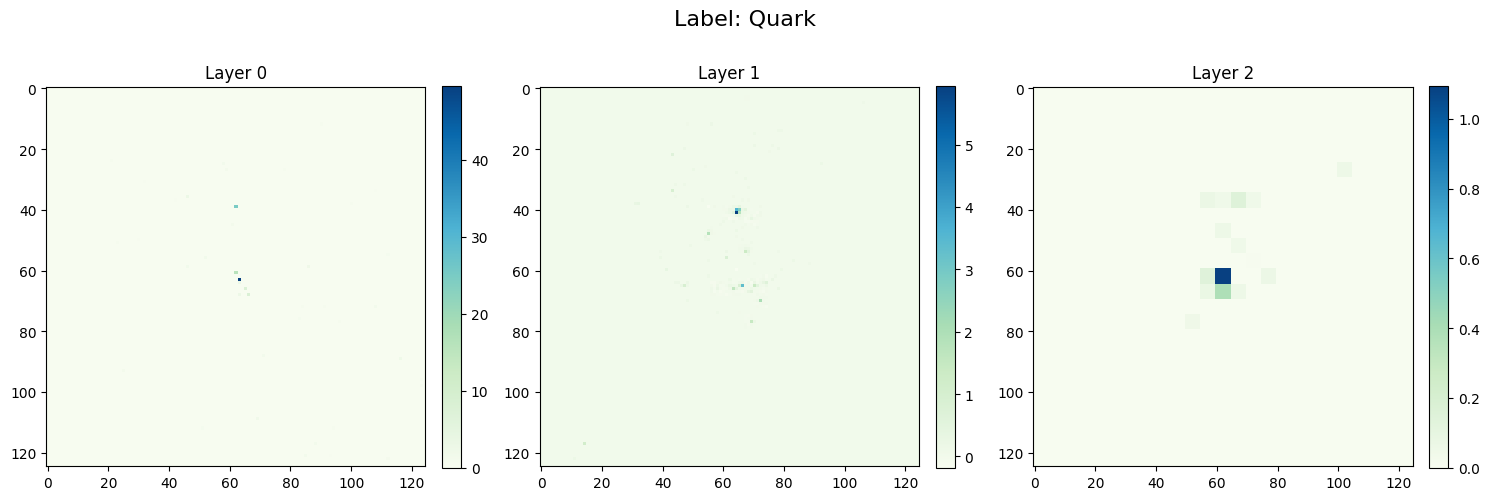

In [ ]:
index = 0
image = X_jets[index]
label = df_batch.iloc[index]['y']
label_str = "Quark" if label == 0.0 else "Gluon"

# Display each layer separately
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

im0 = ax[0].imshow(image[0], cmap='GnBu')
ax[0].set_title("Layer 0")
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(image[1], cmap='GnBu')
ax[1].set_title("Layer 1")
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(image[2], cmap='GnBu')
ax[2].set_title("Layer 2")
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

# Add a single title above all subplots
fig.suptitle(f"Label: {label_str}", fontsize=16, y=1.00)

plt.tight_layout()
plt.show()

In [2]:
# Locate extracted X_jets parquets data
batch_folder = "/content/drive/MyDrive/GSoC/tasks_2_and_3/batches/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540"
x_jets_folder = os.path.join(batch_folder, "X_jets")

# Read and concatenate all the saved X_jets parquet files
X_jets_list = []

for i in range(1, 9):  # There are 21 batches in this folder, but let's just use 8
    x_jets_batch_file = os.path.join(x_jets_folder, f"X_jets_batch_{i}.parquet")
    X_jets_batch = pd.read_parquet(x_jets_batch_file).values
    X_jets_list.append(X_jets_batch.reshape(-1, 125, 125, 3))

X_jets_combined = np.concatenate(X_jets_list, axis=0)

del X_jets_list, x_jets_batch_file, X_jets_batch

# Combine all the pt, m0, and y values from the original dataframes, and we are only using 10 batches
df_all_batches = pd.concat([pd.read_parquet(os.path.join(batch_folder, f"QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540_batch_{i}.parquet")) for i in range(1, 9)], ignore_index=True)
pt_m0_all = df_all_batches[['pt', 'm0']].values
y_all = df_all_batches['y'].values

del df_all_batches

In [3]:
import numpy as np
import cv2
from skimage import feature
from skimage.feature import peak_local_max
from skimage.segmentation import felzenszwalb
import networkx as nx
import json

def laplacian_blob_detector(image, sigma=1.0):
    # Convert the image to a floating-point format
    image = image.astype(np.float32)

    # Apply Laplacian of Gaussian (LoG) filter
    log_image = cv2.GaussianBlur(image, (0, 0), sigma)
    log_image = cv2.Laplacian(log_image, cv2.CV_32F)

    # Find local maxima in the filtered image
    maxima = peak_local_max(log_image, min_distance=1, threshold_abs=0.05, exclude_border=False)

    return maxima

def hessian_blob_detector(image, sigma=1.0):
    # Apply Hessian matrix
    hessian_matrix = feature.hessian_matrix(image, sigma)

    # Compute the eigenvalues of the Hessian matrix
    eigenvalues = feature.hessian_matrix_eigvals(hessian_matrix)

    # Find local maxima in the response function
    local_maxima = feature.peak_local_max(eigenvalues)

    return local_maxima

def graph_based_segmentation(image, scale=100, sigma=0.5, min_size=50):
    # Apply Felzenszwalb-Huttenlocher algorithm for graph-based segmentation
    segments = felzenszwalb(image, scale=scale, sigma=sigma, min_size=min_size)

    return segments

def preprocess_jet_data(jet_images, additional_features, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for idx, image in enumerate(jet_images):
        # Extract features using Laplacian-Blob Detector
        laplacian_features = [laplacian_blob_detector(layer).tolist() for layer in image]

        # Extract features using Hessian-Blob Detector
        hessian_features = [hessian_blob_detector(layer).tolist() for layer in image]

        # Perform graph-based segmentation on each layer
        segmented_images = [graph_based_segmentation(layer).tolist() for layer in image]

        # Save the preprocessed data to a parquet file
        df = pd.DataFrame({'features': [json.dumps((laplacian_features, hessian_features, segmented_images))],
                   'additional_features': [additional_features[idx]]})
        df.to_parquet(os.path.join(output_folder, f'preprocessed_data_{idx}.parquet'))
        del laplacian_features, hessian_features, segmented_images, df

In [4]:
# Preprocess the data
output_folder = '/content/drive/MyDrive/GSoC/task_3/preprocessed_data/jet0_run1_preprocessed_data'
preprocess_jet_data(X_jets_combined, pt_m0_all, output_folder)

In [3]:
num_images = len(X_jets_combined)
del X_jets_combined, pt_m0_all
print(f'There should be a total of {num_images} images.')

There should be a total of 18136 images.


In [4]:
# Read and concatenate all the saved X_jets parquet files
import json

output_folder = '/content/drive/MyDrive/GSoC/task_3/preprocessed_data/jet0_run1_preprocessed_data'
preprocessed_data = []

# List for storing non-skipped batches of data because of google drive crash
processed_indices = []

for idx in range(num_images):
    parquet_file = os.path.join(output_folder, f'preprocessed_data_{idx}.parquet')
    if os.path.exists(parquet_file):
        try:
            df = pd.read_parquet(parquet_file)
            print(f'Reading and appending preprocessed_data_{idx}.parquet')
            preprocessed_data.append((json.loads(df['features'][0]),
                                      df['additional_features'][0]))
            processed_indices.append(idx)
        except Exception as e:
            print(f'Error while processing preprocessed_data_{idx}.parquet: {e}')
            continue
    else:
        print(f'Skipping preprocessed_data_{idx}.parquet as it does not exist')

# Get the corresponding labels
y_processed = y_all[processed_indices]

Streaming output truncated to the last 5000 lines.
Reading and appending preprocessed_data_13136.parquet
Reading and appending preprocessed_data_13137.parquet
Reading and appending preprocessed_data_13138.parquet
Reading and appending preprocessed_data_13139.parquet
Reading and appending preprocessed_data_13140.parquet
Reading and appending preprocessed_data_13141.parquet
Reading and appending preprocessed_data_13142.parquet
Reading and appending preprocessed_data_13143.parquet
Reading and appending preprocessed_data_13144.parquet
Reading and appending preprocessed_data_13145.parquet
Reading and appending preprocessed_data_13146.parquet
Reading and appending preprocessed_data_13147.parquet
Reading and appending preprocessed_data_13148.parquet
Reading and appending preprocessed_data_13149.parquet
Reading and appending preprocessed_data_13150.parquet
Reading and appending preprocessed_data_13151.parquet
Reading and appending preprocessed_data_13152.parquet
Reading and appending preproces

In [5]:
import networkx as nx
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

def add_knn_edges(G, k=5):
    nodes = list(G.nodes(data=True))
    positions = [data["position"] for _, data in nodes]
    node_ids = [node_id for node_id, _ in nodes]
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(positions)
    distances, indices = nbrs.kneighbors(positions)
    
    for idx, neighbors in enumerate(indices):
        current_node = node_ids[idx]
        for neighbor_idx in neighbors:
            if current_node != node_ids[neighbor_idx]:
                G.add_edge(current_node, node_ids[neighbor_idx])

def add_delaunay_edges(G):
    nodes = list(G.nodes(data=True))
    positions = [data["position"] for _, data in nodes]
    node_ids = [node_id for node_id, _ in nodes]
    
    delaunay = Delaunay(positions)
    for simplex in delaunay.simplices:
        for i in range(simplex.size):
            for j in range(i + 1, simplex.size):
                G.add_edge(node_ids[simplex[i]], node_ids[simplex[j]])
def create_graph_from_features(features, additional_features):
    laplacian_features, hessian_features, segmented_images = features

    # Create an empty graph
    G = nx.Graph()

    # Create nodes from Laplacian features and Hessian features
    for layer_idx, (laplacian_layer, hessian_layer) in enumerate(zip(laplacian_features, hessian_features)):
        for laplacian_feature in laplacian_layer:
            node_id = f"L_{layer_idx}_{laplacian_feature[0]}_{laplacian_feature[1]}"
            G.add_node(node_id, feature_type="laplacian", layer=layer_idx, position=tuple(laplacian_feature), features=[1, 0])  # Add node features as a list

        for hessian_feature in hessian_layer:
            node_id = f"H_{layer_idx}_{hessian_feature[0]}_{hessian_feature[1]}"
            G.add_node(node_id, feature_type="hessian", layer=layer_idx, position=tuple(hessian_feature), features=[0, 1])  # Add node features as a list

    # Add global features (mean transverse momentum and mass) as graph attributes
    G.graph["mean_transverse_momentum"] = additional_features[0]
    G.graph["mass"] = additional_features[1]

    # Add k-NN edges
    add_knn_edges(G, k=5)

    # Add Delaunay edges
    add_delaunay_edges(G)

    return G

In [6]:
from networkx.readwrite import json_graph

graph_output_folder = '/content/drive/MyDrive/GSoC/task_3/graph_data/new/jet0_run1_graph_data'
os.makedirs(graph_output_folder, exist_ok=True)

jet_graphs = []
for idx, (jet_features, add_features) in enumerate(preprocessed_data):
    jet_graph = create_graph_from_features(jet_features, add_features)
    jet_graphs.append(jet_graph)
    
    # Convert the graph to JSON data
    graph_json_data = json_graph.node_link_data(jet_graph)
    
    # Save the JSON data to a file
    with open(os.path.join(graph_output_folder, f'graph_data_{idx}.json'), 'w') as f:
        json.dump(graph_json_data, f)

In [7]:
!pip install spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 KB 10.9 MB/s eta 0:00:00


In [10]:
def create_spektral_graph(G):
    # Extract the node attributes
    node_attrs = {attr: np.array([d[attr] for _, d in G.nodes(data=True)]) for attr in ["position", "features"]}
    x = node_attrs["features"].astype(np.float32)  # Use node features as input features
    
    # Extract the adjacency matrix and edge attributes
    a = nx.adjacency_matrix(G).astype(np.float32)
    
    return Graph(x=x, a=a)

In [50]:
import tensorflow as tf
import spektral
from spektral.layers import GATConv, ChebConv, GlobalAvgPool
from spektral.data import BatchLoader, Dataset, Graph
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, graphs, **kwargs):
        self.graphs = graphs
        super().__init__(**kwargs)

    def read(self):
        return self.graphs

    def __len__(self):
        return len(self.graphs)

class CustomBatchLoader(BatchLoader):
    def __init__(self, dataset, labels, batch_size, **kwargs):
        self.labels = labels
        super().__init__(dataset, batch_size=batch_size, **kwargs)

    def load(self):
        while True:  # Add while loop to repeat data loading for multiple epochs
            index = 0
            batch_counter = 0
            current_batch = []
            for graph in self.dataset:
                current_batch.append(graph)
                batch_counter += 1
                
                if batch_counter == self.batch_size:
                    batch = self.collate(current_batch)
                    x, a = batch  # Unpack the tuple
                    y = self.labels[index:index + self.batch_size]
                    index += self.batch_size
                    y = y.reshape(-1, 1)  # Reshape the labels to (batch_size, 1)
                    yield (x, a), y
                    
                    batch_counter = 0
                    current_batch = []

# Convert the jet_graphs to a Spektral Graph list
spektral_graphs = [create_spektral_graph(g) for g in jet_graphs]

# Split the data into training and testing sets
train_graph_list, test_graph_list, y_train, y_test = train_test_split(spektral_graphs, y_processed, test_size=0.2)

# Create CustomDataset objects for training and testing
train_dataset = CustomDataset(train_graph_list)
test_dataset = CustomDataset(test_graph_list)

# Create the CustomBatchLoaders for training and testing
batch_size = 32
train_loader = CustomBatchLoader(train_dataset, y_train, batch_size=batch_size)
test_loader = CustomBatchLoader(test_dataset, y_test, batch_size=batch_size)

In [56]:
# Define the JetClassifier using the Keras functional API
def build_jet_classifier():
    x_in = tf.keras.Input(shape=(None, 2), name="X")  # Change input shape to (None, 2)
    a_in = tf.keras.Input(shape=(None, None), sparse=True, name="A")

    x = GATConv(32, attn_heads=4, concat_heads=True)([x_in, a_in])
    x = GATConv(64, attn_heads=4, concat_heads=True)([x, a_in])
    x = GATConv(128, attn_heads=4, concat_heads=True)([x, a_in])

    x = ChebConv(128, K=2)([x, a_in])
    x = ChebConv(64, K=2)([x, a_in])
    x = ChebConv(32, K=2)([x, a_in])

    x = GlobalAvgPool()(x)
    x = tf.keras.layers.Dense(256, activation="gelu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=[x_in, a_in], outputs=x)

    return model

# Instantiate the model
model = build_jet_classifier()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),  # Change the loss function to BinaryCrossentropy
              metrics=["accuracy"])

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X (InputLayer)                 [(None, None, 2)]    0           []                               
                                                                                                  
 A (InputLayer)                 [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 gat_conv_27 (GATConv)          (None, None, 128)    640         ['X[0][0]',                      
                                                                  'A[0][0]']                      
                                                                                           

In [57]:
# Train the model
epochs = 20
history = model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=epochs,
    validation_data=test_loader.load(),
    validation_steps=test_loader.steps_per_epoch,
)

Epoch 1/20
399/399 [==============================] - 225s 557ms/step - loss: 0.7614 - accuracy: 0.5370 - val_loss: 0.6682 - val_accuracy: 0.6156
Epoch 2/20
399/399 [==============================] - 219s 548ms/step - loss: 0.6780 - accuracy: 0.5916 - val_loss: 0.6634 - val_accuracy: 0.6034
Epoch 3/20
399/399 [==============================] - 219s 549ms/step - loss: 0.6733 - accuracy: 0.5974 - val_loss: 0.6566 - val_accuracy: 0.6050
Epoch 4/20
399/399 [==============================] - 220s 553ms/step - loss: 0.6716 - accuracy: 0.5994 - val_loss: 0.6604 - val_accuracy: 0.6072
Epoch 5/20
399/399 [==============================] - 218s 546ms/step - loss: 0.6665 - accuracy: 0.6060 - val_loss: 0.6591 - val_accuracy: 0.6075
Epoch 6/20
399/399 [==============================] - 218s 545ms/step - loss: 0.6807 - accuracy: 0.6024 - val_loss: 0.6569 - val_accuracy: 0.6097
Epoch 7/20
399/399 [==============================] - 219s 549ms/step - loss: 0.6654 - accuracy: 0.6054 - val_loss: 0.6605 -

In [58]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch)

100/100 [==============================] - 18s 176ms/step - loss: 0.6563 - accuracy: 0.6144


In [70]:
model.save_weights('/content/drive/MyDrive/GSoC/task_3/model/model_jet0_run1_weights.h5')

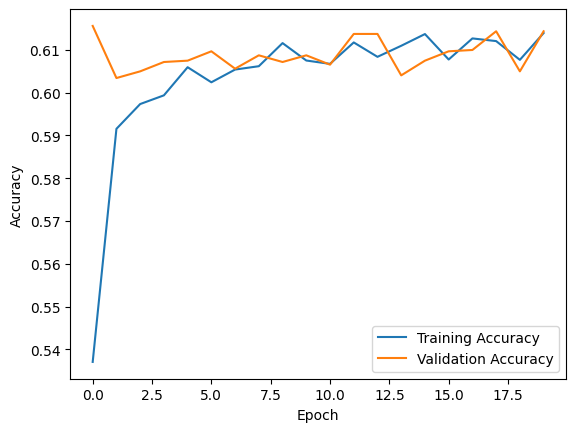

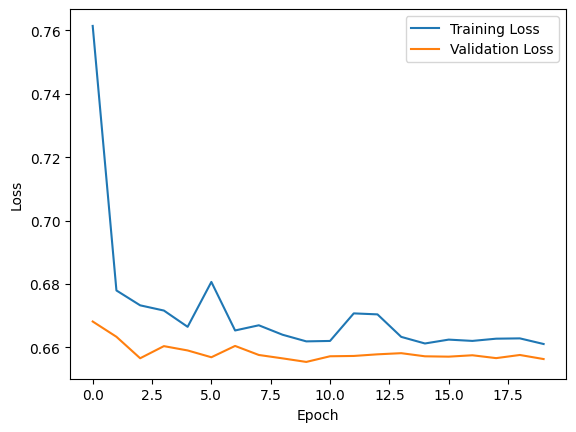

In [71]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [72]:
def load(self, repeat=False):
    while True:
        index = 0
        batch_counter = 0
        current_batch = []
        for graph in self.dataset:
            current_batch.append(graph)
            batch_counter += 1

            if batch_counter == self.batch_size:
                batch = self.collate(current_batch)
                x, a = batch
                y = self.labels[index:index + self.batch_size]
                index += self.batch_size
                y = y.reshape(-1, 1)
                yield (x, a), y

                batch_counter = 0
                current_batch = []

        if not repeat:
            break

3192/3192 [==============================] - 27s 8ms/step


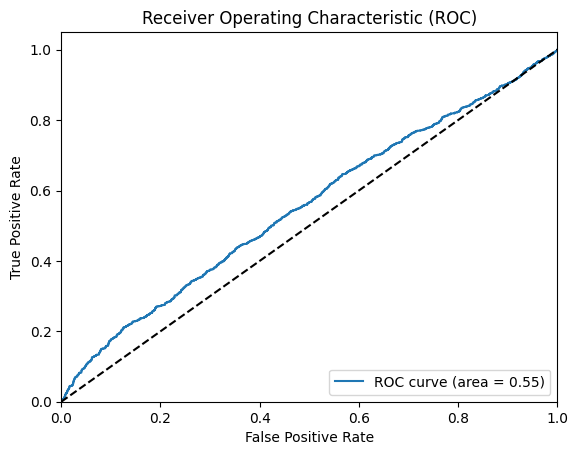

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score

# Create a CustomBatchLoader with batch_size=1 for predictions
pred_loader = CustomBatchLoader(test_dataset, y_test, batch_size=1)

# Get predictions
y_pred = model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch)
y_pred = y_pred.squeeze()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()